Create G-K templates from GAIA data cross-matched with 2Mass

In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math
import pandas as pd
from numpy import genfromtxt

# Functions

In [4]:
def cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source,s1):
    Source = t["Source"]
    Gmag = t["__Gmag_"]
    #Using Gmag in place of Vmag and Bmag to calculate Vmags and Bmags
    Vmag = t["__Gmag_"]
    Bmag = t["__Gmag_"]
    Jmag = t["Jmag"]
    Hmag = t["Hmag"]
    Kmag = t["Kmag"]
    QFlags = t["Qfl"]
    s1= t["d_arcsec"]
    plx = t['Plx']
    dup = t['Dup'] 
    #Masks data values 
    
    rows_to_remove = np.array([])
    # mask all data that does not have a Qfl value of A
    for i in range(0,len(QFlags)):
        if(QFlags[i][0] == ord("A")):
            Jmag.mask[i] = False
        else:
            Gmag.mask[i] = True
            Jmag.mask[i] = True
            Kmag.mask[i] = True
            Hmag.mask[i] = True
            rows_to_remove = np.append(rows_to_remove,i)
            
    for i in range(0,len(QFlags)):
        if(QFlags[i][2] == ord("A")):
            Kmag.mask[i] = False
        else:
            Gmag.mask[i] = True
            Jmag.mask[i] = True
            Kmag.mask[i] = True
            Hmag.mask[i] = True  
            rows_to_remove = np.append(rows_to_remove,i)
        
    for i in range(0,len(QFlags)):
        if(QFlags[i][1] == ord("A")):
            Hmag.mask[i] = False
        else:
            Gmag.mask[i] = True
            Jmag.mask[i] = True
            Kmag.mask[i] = True
            Hmag.mask[i] = True
            rows_to_remove = np.append(rows_to_remove,i)
            
    #mask all values with dup = 1
    imask = 0
    for i in range(0,len(dup)):
        if (dup[i] > 0.5):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            rows_to_remove = np.append(rows_to_remove,i)
            for col in cols:
                col.mask[i] = True
    for i in range(0,len(dup)):
        if(dup[i] > 0.5):
            print(i,dup[i])
    print("Masked ",imask," rows in which dup is equal to 1")
    
    #remove dupliacte matches for GAIA
    Test = Source.compressed()
    unique = set()
    Gdups = set()

    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("GAIA Duplicate Source: ",Test[i])
            Gdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Gdups):
                row = t[i]
                idx = row._index
                cols = row._table.columns.values()
                rows_to_remove = np.append(rows_to_remove,i)
                for col in cols:
                    col.mask[i] = True
    print("Finished masking all GAIA duplicates. All sources involved")
    
    #remove dupliacte matches for 2MASS
    TwoM = t["_2MASS"]
    unique = set()
    Tdups = set()
    Test = TwoM.compressed()
    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("2MASS Duplicate Source: ",Test[i])
            Tdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))
    
    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Tdups):
                row = t[i]
                idx = row._index
                cols = row._table.columns.values()
                rows_to_remove = np.append(rows_to_remove,i)
                for col in cols:
                    col.mask[i] = True
    print("Finished masking all 2MASS duplicates. All sources involved")

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Tdups or Name in Gdups):
                print(Source[i],s1[i],Gmag[i],Vmag[i]-Gmag[i],Jmag[i],Kmag[i],TwoM[i])
                
    #masked rows with J-G greater than 3 sigma from mean
    J_G = Jmag-Gmag
    JGmean = np.mean(J_G)
    JGstd = np.std(J_G)
    imask = 0
    for i in range(0,len(J_G)):
        if(abs(J_G[i] - JGmean) > 3*JGstd):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            rows_to_remove = np.append(rows_to_remove,i)
            for col in cols:
                col.mask[i] = True
    print("Masked ",imask," rows based on J-G color > 3 sigma from mean")
           
    return rows_to_remove,t

In [5]:
def AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag):
    #Calculate distance, and absolute magnitudes
    
    Dist = ma.array([])
    Vmags = ma.array([])
    Bmags = ma.array([])
    Gmags = ma.array([])
    Jmags = ma.array([])
    Hmags = ma.array([])
    Kmags = ma.array([])

    Dist = 1000./plx
    Vmags = Vmag - 5 * np.log10(Dist) + 5
    Bmags = Bmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag -5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    
    return Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags

In [6]:
def ColorClassification(Gmags,Kmags,colors):    
    #split the stars into different categories based on G-K
    
    G_K = Gmags-Kmags
    color = np.ones(len(G_K))*1000
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [7]:
def CreateTemplates(color,colors,wvl,wvl2,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags):
    #for each color class, a template is created of the absolute magnitudes of the stars and their color indices
    
    G_K = Gmags-Kmags
    avg_colors = np.array([])
    err_colors = np.array([])
    stars = np.array([])
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_B_array = ma.array([])
        G_V_array = ma.array([])
        G_J_array = ma.array([])
        G_H_array = ma.array([])
        G_K_array = ma.array([])
        B = ma.array([])
        V = ma.array([])
        G = ma.array([])
        J = ma.array([])
        H = ma.array([])
        K = ma.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(G_K)):
            if (color[i] == c):
                G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
                G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                B = np.append(B,Bmags[i])
                V = np.append(V,Vmags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,Jmags[i])
                H = np.append(H,Hmags[i])
                K = np.append(K,Kmags[i])
                star_count = star_count +1
        #average G-K value
        avg_colors = np.append(avg_colors,np.mean(G_K_array))
        err_colors = np.append(err_colors,np.std(G_K_array))
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.mean(G_B_array), np.mean(G_V_array),\
                     np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
        std_array = [np.std(G_B_array), np.std(G_V_array), \
                     np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
        #absolute SED
        mag_array2 = [np.mean(B), np.mean(V), np.mean(G), \
                      np.mean(J), np.mean(H), np.mean(K)]
        std_array2 = [np.std(B), np.std(V), np.std(G), \
                      np.std(J), np.std(H), np.std(K)]
        #add standard deviation error
        
        val = np.sqrt(len(G_B_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(B))
        std_array4 = std_array2/val2
        
        #stack SEDs
        if (c == colors[0]):
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [8]:
def CreatePlots(colors,wvl,wvl2,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots
    
    #plot average absolute magnitude in each filter for each color 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        ax.errorbar(wvl2, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each color 
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        ax2.errorbar(wvl, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution')
    box2 = ax.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [9]:
def PrintToFile(colors,stars,color_mags,color_std,color_std_err,name):
    
    rows = len(colors)
    colors2 = np.zeros([rows,1])
    stars2 = np.zeros([rows,1])
    for i in range(rows):
        colors2[i,0] = colors[i]
        stars2[i,0] = stars[i]
    
    arrays=[stars2,color_mags,color_std,color_std_err]

    # Create an array to return to
    FinalTemplate = colors2

    for array in arrays:
        FinalTemplate = np.concatenate([FinalTemplate, array],axis = 1)
        
    columns = 'color,number_of_stars,G_B,G_V,G_J,G_H,G_K,G_B_std,G_V_std,G_J_std,G_H_std,G_K_std,' + \
            'G_B_std_err,G_V_std_err,G_J_std_err,G_H_std_err,G_K_std_err'
        
    np.savetxt(name, FinalTemplate, delimiter=",",header = columns)
    
    return FinalTemplate

# Read in Data and Create Templates

In [10]:
from astropy.table import Table
t = Table.read('../dr1_200pc_2Mass.vot', format='votable')

print("The astropy reader loads the data into the following variable names:")
print(t.colnames)
print("\nThe number of stars is " + str(len(t)))

#Rename columns
Source = t["Source"]
Gmag = t["__Gmag_"]
#Using Gmag in place of Vmag and Bmag to calculate Vmags and Bmags
Vmag = t["__Gmag_"]
Bmag = t["__Gmag_"]
Jmag = t["Jmag"]
Hmag = t["Hmag"]
Kmag = t["Kmag"]
QFlags = t["Qfl"]
s1= t["d_arcsec"]
plx = t['Plx']
dup = t['Dup'] 

wvl = [420, 477, 1235, 1662, 2159]
wvl2 = [420, 477, 673,1235, 1662, 2159]

rows_to_remove,t = cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source,s1)

rows_to_remove2 = rows_to_remove.astype(int)
rows_to_remove3 = np.unique(rows_to_remove2)
t.remove_rows(rows_to_remove3)

#Rename columns
Source = t["Source"]
Gmag = t["__Gmag_"]
#Using Gmag in place of Vmag and Bmag to calculate Vmags and Bmags
Vmag = t["__Gmag_"]
Bmag = t["__Gmag_"]
Jmag = t["Jmag"]
Hmag = t["Hmag"]
Kmag = t["Kmag"]
QFlags = t["Qfl"]
s1= t["d_arcsec"]
plx = t['Plx']
dup = t['Dup'] 

Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags = AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag)

The astropy reader loads the data into the following variable names:
['d_arcsec', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', '_2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']

The number of stars is 191206
Masked  72230  rows in which dup is equal to 1
GAIA Duplicate Source:  5555073729568686592
GAIA Duplicate Source:  5859121851795522560
GAIA Duplicate Source:  101700874199870208
GAIA Duplicate Source:  5621620502608043264
GAIA Duplicate Source:  4340260028239519232
GAIA Duplicate Source:  6038042561484950016
GAIA Duplicate Source:  1147294066657043456
GAIA Duplicate Source:  4328234841366192000
GAIA Duplicate Source:  3262302333060747392
GAIA Duplicate Source:  3416890094513036800
GAIA Duplicate Source:  2984035009725892352
GAIA Duplicate Source:  3324242049302232832
GAIA Duplicate Sou

GAIA Duplicate Source:  3782510696097914368
GAIA Duplicate Source:  1134618759172982528
GAIA Duplicate Source:  5987792852871028480
GAIA Duplicate Source:  3458954385736082432
GAIA Duplicate Source:  6348780593492807936
GAIA Duplicate Source:  3870609786827670784
GAIA Duplicate Source:  3679803150283421824
GAIA Duplicate Source:  1631569908662484992
GAIA Duplicate Source:  2731572605822353152
GAIA Duplicate Source:  321511184375355264
GAIA Duplicate Source:  3441630549249136256
GAIA Duplicate Source:  5959478126358758016
GAIA Duplicate Source:  3170303755624614528
GAIA Duplicate Source:  2225421705102219776
GAIA Duplicate Source:  6649211872221271296
GAIA Duplicate Source:  5632435573858083968
GAIA Duplicate Source:  3808918903812996992
GAIA Duplicate Source:  2987751290308221440
GAIA Duplicate Source:  3432846791370889472
GAIA Duplicate Source:  3752121500375725568
GAIA Duplicate Source:  3557719289010927744
GAIA Duplicate Source:  2086063176129332224
GAIA Duplicate Source:  252141504

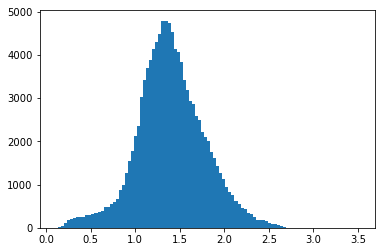

In [21]:
#histogram with no clean data
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

plt.hist(x,100)
plt.show()

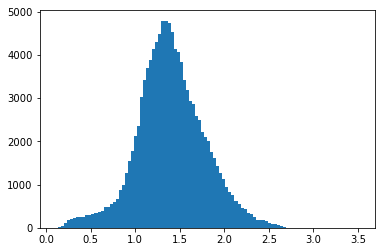

In [20]:
#histogram with cleaned data
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

m_arr_mask = np.ones(len(x))
for i in range(len(x)):
    if Gmag.mask[i] == True:
        m_arr_mask[i] = 0

plt.hist(x,100)
plt.show()

#for i in range(len(x)):
#    if x[i] > 3:
#        print(i,'and',x[i])

In [18]:
print(m_arr_mask)
print(len(m_arr_mask))
print

[ 0.  0.  0. ...,  0.  0.  0.]
191206


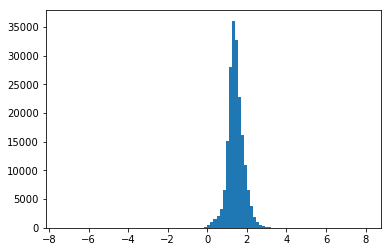

In [27]:
x2  = Gmags-Jmags
plt.hist(x,100)
plt.show()

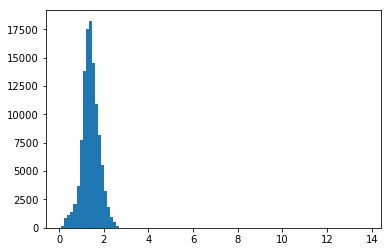

In [22]:
x2  = Gmags-Jmags
plt.hist(x,100,weights=m_arr_mask)
plt.show()

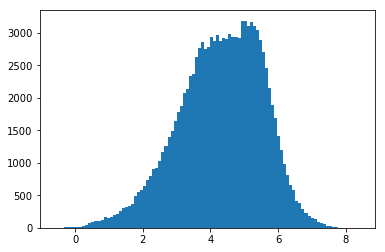

30055 and 7.26998
55044 and 7.12311
68447 and 7.01428
74498 and 7.09847
76265 and 7.6851
80116 and 7.57853
83622 and 7.02005
83642 and 7.08605
83693 and 7.00605
84436 and 7.50509
85199 and 7.06941
88203 and 7.30485
89907 and 7.31564
90563 and 7.1069
90882 and 7.07229
92406 and 7.11413
93969 and 7.05146
94281 and 7.00333
95035 and 7.00708
95772 and 7.49066
95917 and 7.08781
96062 and 7.00708
96106 and 7.04614
96109 and 7.21614
96182 and 7.0912
96363 and 7.01443
96489 and 8.23358
96875 and 7.14889
96917 and 7.08392
97008 and 7.083
97076 and 7.05202
97541 and 7.02115
97681 and 7.02014
97908 and 7.14309
97974 and 7.00205
98129 and 7.85996
98274 and 7.06385
98501 and 7.13566
98517 and 7.04861
98741 and 7.06932
98854 and 7.16315
99131 and 7.11769
99234 and 7.01347
99343 and 7.10323
99352 and 7.03123
99395 and 7.02615
99821 and 7.18692
99919 and 7.12371
100117 and 7.88903
100181 and 7.20779
100341 and 7.29816
100427 and 7.0759
100869 and 7.16619
100969 and 7.06973
101134 and 7.24709
101236 an

In [22]:
plt.hist(Gmags,100)
plt.show()

count = 0
for i in range(len(Gmags)):
    if Gmags[i] > 7:
        print(i,'and',Gmags[i])
        count = count+1
print(count)

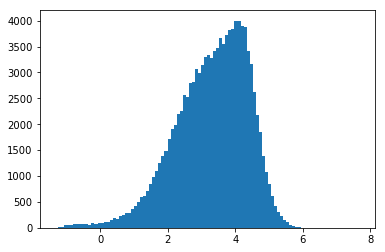

100117 and 7.08903
107656 and 7.67062
2


In [23]:
plt.hist(Jmags,100)
plt.show()

count = 0
for i in range(len(Jmags)):
    if Jmags[i] > 7:
        print(i,'and',Jmags[i])
        count = count+1
print(count)

In [49]:
print(m_arr_mask)

[ 1.  1.  1. ...,  1.  1.  1.]


In [47]:
a = min(x)
b = max(x)
print(a)
print(b)

--
--


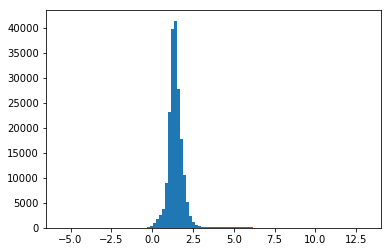

In [12]:
#histogram with qfl values masked
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

plt.hist(x,100)
plt.show(

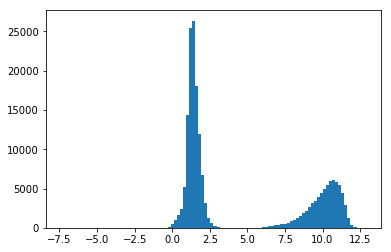

In [15]:
#histogram with dup values masked
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

plt.hist(x,100)
plt.show()

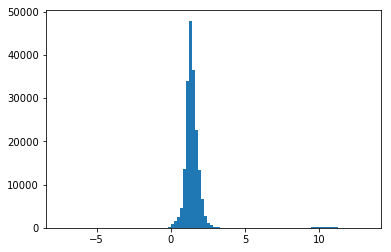

In [34]:
#histogram with gaia and 2mass duplicates masked
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

plt.hist(x,100)
plt.show()

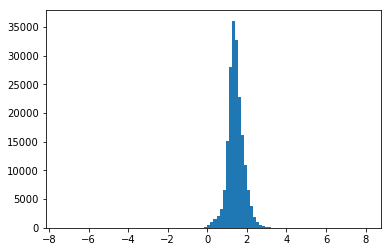

In [28]:
#histogram with 2mass duplicates masked
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

plt.hist(x,100)
plt.show()

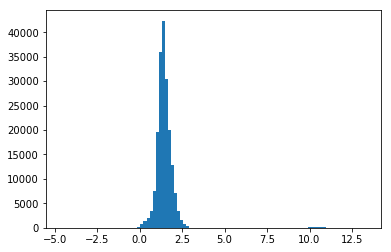

In [21]:
#histogram with j-g > 3 sigma removed 
G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2

plt.hist(x,100)
plt.show()

In [13]:
count = 0 
for i in range(len(t)):
    if Source.mask[i] == True:
        count = count+1
print(count)

74287


In [ ]:
#Templates

#Template.csv  colors = [0.5,1,1.5,2,2.5,3] 
#Template2.csv colors = np.arange(0.1,3,0.1)
#Template3.csv colors = np.arange(-0.5,4,0.25)
#Template4.csv colors = np.arange(-0.5,4,0.5)
#Template5.csv colors = np.arange(0.25,3,0.25)
#Template6.csv colors = np.arange(0.2,3,0.2)
#Template7.csv colors = np.arange(0.15,4,0.15)


In [95]:
#classify stars according to color and creates templates
colors = np.arange(0.2,3,0.2)
name ="Template6.csv"

color = ColorClassification(Gmags,Kmags,colors)
stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,wvl,wvl2,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags)
finaltemplate = PrintToFile(colors,stars,color_mags,color_std,color_std_err,name)

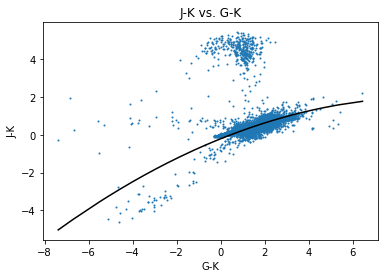

In [13]:
#Plot of J-K against G-K with fittings

G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2
plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = -0.215+0.468*x2-0.025*np.power(x2,2)
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

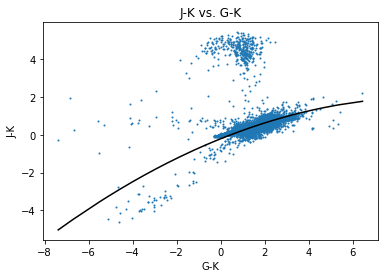

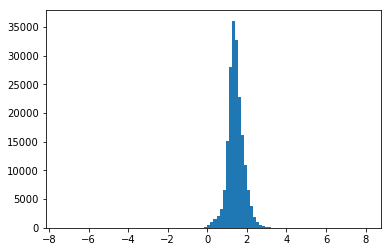

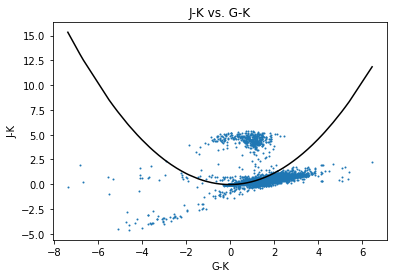

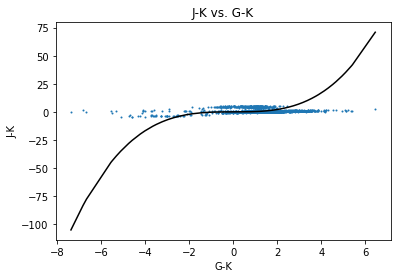

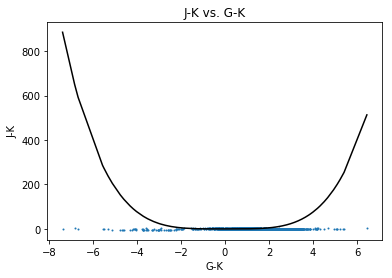

In [11]:
#Plot of J-K against G-K with fittings

G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2
plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = -0.215+0.468*x2-0.025*np.power(x2,2)
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.hist(x,100)
plt.show()

#polyfit
[a,b,c] = np.polyfit(x,y,2)
[a2,b2,c2,d2] = np.polyfit(x,y,3)
[a3,b3,c3,d3,e3] = np.polyfit(x,y,4)

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a*x2+b*np.power(x2,2) + c
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a2*x2+b2*np.power(x2,2)+c2*np.power(x2,3) + d2
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a3*x2+b3*np.power(x2,2)+c3*np.power(x2,3) + d3*np.power(x2,4) +e3
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

#polyeval

1


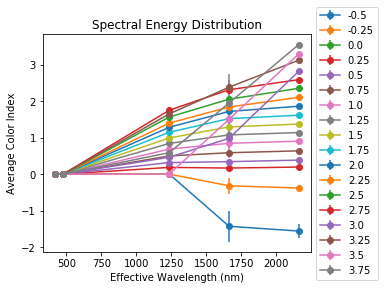

In [38]:
#Template3
my_data = genfromtxt('Template3.csv', delimiter=',')

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,11] >= 0.25:
        count = count+1
print(count)



ax2 = plt.subplot(111)
for i in range(len(my_data)):
    ax2.errorbar(wvl, my_data[i,2:7], yerr = my_data[i,12:17], linestyle = '-', marker = 'o',label = str(my_data[i,0]))
ax2.set_xlabel('Effective Wavelength (nm)')
ax2.set_ylabel('Average Color Index')
ax2.set_title('Spectral Energy Distribution')
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

0


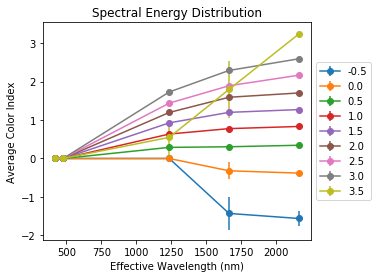

In [36]:
#Template4
my_data = genfromtxt('Template4.csv', delimiter=',')

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,11] >= 0.5:
        count = count+1
print(count)

ax2 = plt.subplot(111)
for i in range(len(my_data)):
    ax2.errorbar(wvl, my_data[i,2:7], yerr = my_data[i,12:17], linestyle = '-', marker = 'o',label = str(my_data[i,0]))
ax2.set_xlabel('Effective Wavelength (nm)')
ax2.set_ylabel('Average Color Index')
ax2.set_title('Spectral Energy Distribution')
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

0


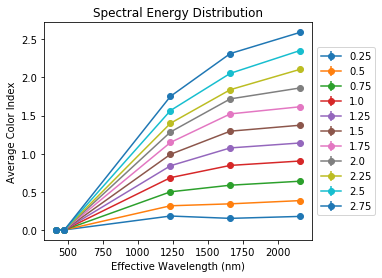

In [37]:
#Template5
my_data = genfromtxt('Template5.csv', delimiter=',')

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,11] >= 0.25:
            count = count+1
print(count)


ax2 = plt.subplot(111)
for i in range(len(my_data)):
    ax2.errorbar(wvl, my_data[i,2:7], yerr = my_data[i,12:17], linestyle = '-', marker = 'o',label = str(my_data[i,0]))
ax2.set_xlabel('Effective Wavelength (nm)')
ax2.set_ylabel('Average Color Index')
ax2.set_title('Spectral Energy Distribution')
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [22]:
#Template6
my_data = genfromtxt('Template6.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.2:
            count = count+1
print(count)

[[ 0.2         0.06636118  0.15217309  0.          0.          0.08894473
   0.04536824  0.06636118  0.          0.          0.08285687  0.15498821
   0.15217309]
 [ 0.4         0.31016344  0.05676153  0.          0.          0.26030917
   0.27002416  0.31016344  0.          0.          0.05611001  0.06239017
   0.05676153]
 [ 0.6         0.50638975  0.0569913   0.          0.          0.40618598
   0.4605      0.50638975  0.          0.          0.06297733  0.06695607
   0.0569913 ]
 [ 0.8         0.70963741  0.05707592  0.          0.          0.55022823
   0.65449063  0.70963741  0.          0.          0.06972345  0.08001416
   0.05707592]
 [ 1.          0.91867421  0.05590432  0.          0.          0.69621781
   0.86133521  0.91867421  0.          0.          0.07073725  0.08252644
   0.05590432]
 [ 1.2         1.11167886  0.05584504  0.          0.          0.82306738
   1.04832877  1.11167886  0.          0.          0.06962087  0.08310266
   0.05584504]
 [ 1.4         1.30289

In [31]:
#Template7
my_data = genfromtxt('Template7.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,11] >= 0.15:
            count = count+1
print(count)


[[  1.50000000e-01   6.29000000e+02   0.00000000e+00   0.00000000e+00
    6.22225952e-02   1.07249691e-02   2.80492893e-02   0.00000000e+00
    0.00000000e+00   7.81930052e-02   1.65151217e-01   1.59922238e-01]
 [  3.00000000e-01   7.44000000e+02   0.00000000e+00   0.00000000e+00
    2.02223125e-01   1.95095435e-01   2.29837365e-01   0.00000000e+00
    0.00000000e+00   4.73753163e-02   5.20473981e-02   4.33547704e-02]
 [  4.50000000e-01   1.08900000e+03   0.00000000e+00   0.00000000e+00
    3.11032132e-01   3.34567489e-01   3.76656553e-01   0.00000000e+00
    0.00000000e+00   4.96280234e-02   5.55118530e-02   4.27841406e-02]
 [  6.00000000e-01   1.42600000e+03   0.00000000e+00   0.00000000e+00
    4.20835223e-01   4.80189343e-01   5.27549087e-01   0.00000000e+00
    0.00000000e+00   5.98736277e-02   5.83007114e-02   4.31368687e-02]
 [  7.50000000e-01   2.07700000e+03   0.00000000e+00   0.00000000e+00
    5.30144453e-01   6.26812725e-01   6.80836798e-01   0.00000000e+00
    0.00000000e+

In [2]:
coeff = genfromtxt('Coeff_extinct.csv', delimiter=',')
print(coeff)

a1g = coeff[1,1]
a2g = coeff[1,2]
a3g = coeff[1,3]
a4g = coeff[1,4]
a5g = coeff[1,5]
a6g = coeff[1,6]
a7g = coeff[1,7]

a1j = coeff[2,1]
a2j = coeff[2,2]
a3j = coeff[2,3]
a4j = coeff[2,4]
a5j = coeff[2,5]
a6j = coeff[2,6]
a7j = coeff[2,7]

a1k = coeff[3,1]
a2k = coeff[3,2]
a3k = coeff[3,3]
a4k = coeff[3,4]
a5k = coeff[3,5]

[[             nan              nan              nan              nan
               nan              nan              nan              nan]
 [             nan   8.82095056e-01  -8.67802360e-02   1.51157300e-02
   -2.96382900e-03  -2.70547180e-02   5.44945000e-04   2.60413500e-03]
 [             nan   2.43062354e-01  -1.89947600e-03   1.40615000e-04
    2.58000000e-05  -2.69124000e-04   8.45000000e-07   4.86000000e-06]
 [             nan   8.60254320e-02   9.23000000e-05   3.32000000e-06
   -1.65000000e-05  -2.00000000e-05              nan              nan]]


6
0


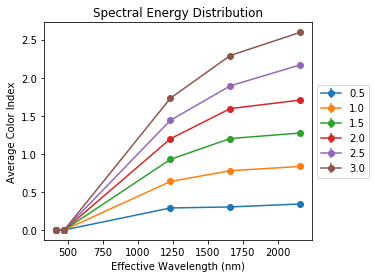

[[  5.00000000e-01   2.28600000e+03   0.00000000e+00   0.00000000e+00
    2.88251093e-01   3.01848641e-01   3.40586168e-01   0.00000000e+00
    0.00000000e+00   8.42945378e-02   1.32509514e-01   1.31702107e-01
    0.00000000e+00   0.00000000e+00   1.76303657e-03   2.77146213e-03
    2.75457505e-03]
 [  1.00000000e+00   1.16270000e+04   0.00000000e+00   0.00000000e+00
    6.36570918e-01   7.77539007e-01   8.33544511e-01   0.00000000e+00
    0.00000000e+00   1.11744834e-01   1.46077865e-01   1.36103225e-01
    0.00000000e+00   0.00000000e+00   1.03631938e-03   1.35472322e-03
    1.26221861e-03]
 [  1.50000000e+00   5.80630000e+04   0.00000000e+00   0.00000000e+00
    9.27351910e-01   1.20062827e+00   1.27265005e+00   0.00000000e+00
    0.00000000e+00   1.05566942e-01   1.45776563e-01   1.34933497e-01
    0.00000000e+00   0.00000000e+00   4.38104997e-04   6.04975758e-04
    5.59976807e-04]
 [  2.00000000e+00   3.47550000e+04   0.00000000e+00   0.00000000e+00
    1.19770206e+00   1.5936885

IndexError: index 17 is out of bounds for axis 0 with size 6

In [70]:
#read in templates
from numpy import genfromtxt

#Template1
my_data = genfromtxt('Template.csv', delimiter=',')
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,11] >= 0.5:
        count = count+1
print(count)

wvl = [420, 477, 1235, 1662, 2159]
ax2 = plt.subplot(111)

for i in range(len(my_data)):
    ax2.errorbar(wvl, my_data[i,2:7], yerr = my_data[i,12:17], linestyle = '-', marker = 'o',label = str(my_data[i,0]))
ax2.set_xlabel('Effective Wavelength (nm)')
ax2.set_ylabel('Average Color Index')
ax2.set_title('Spectral Energy Distribution')
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print(my_data)

for i in range(17,17+9*2):
    plt.plot([wvl[2],wvl[3]],[my_data[i],my_data[i+9*2]])
    plt.show()

1


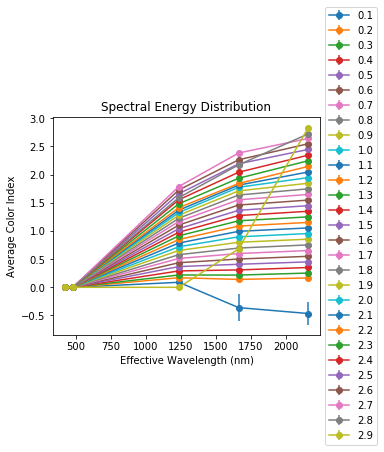

[[  1.00000000e-01   1.40000000e+01   0.00000000e+00   0.00000000e+00
    8.90714441e-02  -3.60357182e-01  -4.64928661e-01   0.00000000e+00
    0.00000000e+00   2.02012576e-01   8.74664204e-01   7.38246587e-01
    0.00000000e+00   0.00000000e+00   5.39901320e-02   2.33763841e-01
    1.97304700e-01]
 [  2.00000000e-01   2.35000000e+02   0.00000000e+00   0.00000000e+00
    1.70234067e-01   1.40221267e-01   1.66327673e-01   0.00000000e+00
    0.00000000e+00   3.03430432e-02   4.08305766e-02   2.44282624e-02
    0.00000000e+00   0.00000000e+00   1.97936189e-03   2.66349314e-03
    1.59352414e-03]
 [  3.00000000e-01   5.16000000e+02   0.00000000e+00   0.00000000e+00
    2.19038758e-01   2.17282954e-01   2.53222863e-01   0.00000000e+00
    0.00000000e+00   4.23726844e-02   3.97699519e-02   2.83776326e-02
    0.00000000e+00   0.00000000e+00   1.86535342e-03   1.75077451e-03
    1.24925562e-03]
 [  4.00000000e-01   7.19000000e+02   0.00000000e+00   0.00000000e+00
    2.91119603e-01   3.0881223

In [63]:
#Template2
my_data2 = genfromtxt('Template2.csv', delimiter=',')

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data2)):
    if my_data2[i,11] >= 0.1:
        count = count+1
print(count)


wvl = [420, 477, 1235, 1662, 2159]
ax2 = plt.subplot(111)
for i in range(len(my_data2)):
    ax2.errorbar(wvl, my_data2[i,2:7], yerr = my_data2[i,12:17], linestyle = '-', marker = 'o',label = str(my_data2[i,0]))
ax2.set_xlabel('Effective Wavelength (nm)')
ax2.set_ylabel('Average Color Index')
ax2.set_title('Spectral Energy Distribution')
box2 = ax2.get_position()
ax2.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print(my_data2)

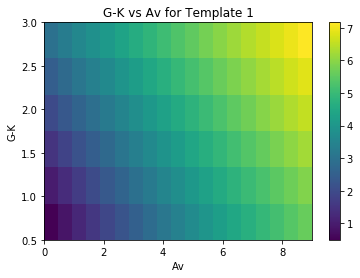

In [53]:
Av = np.arange(0,9.5,0.5)
map_array = np.ones((len(my_data),len(Av)))
kg_array = np.ones((len(my_data),len(Av)))
kk_array = np.ones((len(my_data),len(Av)))
for i in range(len(my_data)):
    for j in range(len(Av)):
        data = my_data[i,0]
        Avj = Av[j]
        kg_array[i,j] = a1g + a2g*data + a3g*math.pow(data,2) + \
                         a4g*math.pow(data,3) + a5g*Avj + a6g*math.pow(Avj,2) + \
                         a7g*data*Avj
        kk_array[i,j] = a1k + a2k*data + a3k*math.pow(data,2) + \
                         a4k*math.pow(data,3) + a5k*Avj
        map_array[i,j] = data + (kg_array[i,j] - kk_array[i,j])*Avj
                
plt.imshow(map_array, origin='lower',extent=[min(Av),max(Av),my_data[0,0],my_data[len(my_data)-1,0]],aspect='auto')
plt.xlabel('Av')
plt.ylabel('G-K')
plt.title('G-K vs Av for Template 1')
plt.colorbar()
plt.show()

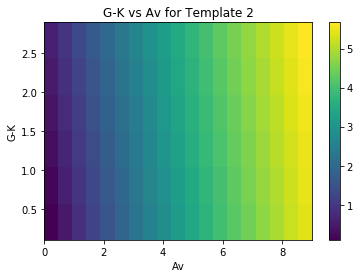

In [54]:
Av = np.arange(0,9.5,0.5)
map_array2 = np.ones((len(my_data),len(Av)))
kg_array = np.ones((len(my_data),len(Av)))
kk_array = np.ones((len(my_data),len(Av)))
for i in range(len(my_data)):
    for j in range(len(Av)):
        data2 = my_data2[i,0]
        Avj = Av[j]
        kg_array[i,j] = a1g + a2g*data2 + a3g*math.pow(data2,2) + \
                         a4g*math.pow(data2,3) + a5g*Avj + a6g*math.pow(Avj,2) + \
                         a7g*data2*Avj
        kk_array[i,j] = a1k + a2k*data2 + a3k*math.pow(data2,2) + \
                         a4k*math.pow(data2,3) + a5k*Avj
        map_array2[i,j] = data2 + (kg_array[i,j] - kk_array[i,j])*Avj
        
plt.imshow(map_array2, origin='lower',extent=[min(Av),max(Av),my_data2[0,0],my_data2[len(my_data2)-1,0]],aspect='auto')
plt.title('G-K vs Av for Template 2')
plt.xlabel('Av')
plt.ylabel('G-K')
plt.colorbar()
plt.show()

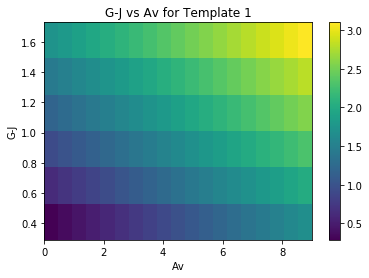

In [55]:
Av = np.arange(0,9.5,0.5)
map_array3 = np.ones((len(my_data),len(Av)))
kj_array = np.ones((len(my_data),len(Av)))
kk_array = np.ones((len(my_data),len(Av)))
for i in range(len(my_data)):
    for j in range(len(Av)):
        data = my_data[i,4]
        Avj = Av[j]
        kj_array[i,j] = a1j + a2j*data + a3j*math.pow(data,2) + \
                         a4j*math.pow(data,3) + a5j*Avj + a6j*math.pow(Avj,2) + \
                         a7j*data*Avj
        kk_array[i,j] = a1k + a2k*data + a3k*math.pow(data,2)+ \
                         a4k*math.pow(data,3) + a5k*Avj
        map_array3[i,j] = data + (kj_array[i,j] - kk_array[i,j])*Avj
                
plt.imshow(map_array3, origin='lower',extent=[min(Av),max(Av),my_data[0,4],my_data[len(my_data)-1,4]],aspect='auto')
plt.xlabel('Av')
plt.ylabel('G-J')
plt.title('G-J vs Av for Template 1')
plt.colorbar()
plt.show()

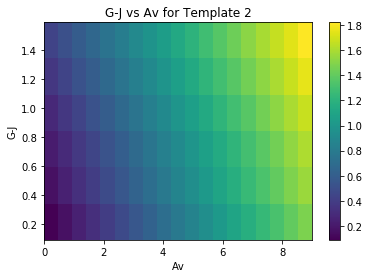

In [56]:
Av = np.arange(0,9.5,0.5)
map_array4 = np.ones((len(my_data),len(Av)))
kj_array = np.ones((len(my_data),len(Av)))
kk_array = np.ones((len(my_data),len(Av)))
for i in range(len(my_data)):
    for j in range(len(Av)):
        data2 = my_data2[i,4]
        Avj = Av[j]
        kj_array[i,j] = a1j + a2j*data2 + a3j*math.pow(data2,2) + \
                         a4j*math.pow(data2,3) + a5j*Avj + a6j*math.pow(Avj,2) + \
                         a7j*data2*Avj
        kk_array[i,j] = a1k + a2k*data2+ a3k*math.pow(data2,2) + \
                         a4k*math.pow(data2,3) +a5k*Avj
        map_array4[i,j] = data2 + (kj_array[i,j] - kk_array[i,j])*Avj
                
plt.imshow(map_array4, origin='lower',extent=[min(Av),max(Av),my_data2[0,4],my_data2[len(my_data2)-2,4]],aspect='auto')
plt.xlabel('Av')
plt.ylabel('G-J')
plt.title('G-J vs Av for Template 2')
plt.colorbar()
plt.show()

In [67]:
#Create Template 1_2

my_data = np.append(my_data,map_array,axis = 1)
my_data = np.append(my_data,map_array3, axis = 1)
print(my_data)
np.savetxt('Template1_2.csv',my_data, delimiter=",")

[[  5.00000000e-01   2.28600000e+03   0.00000000e+00   0.00000000e+00
    2.88251093e-01   3.01848641e-01   3.40586168e-01   0.00000000e+00
    0.00000000e+00   8.42945378e-02   1.32509514e-01   1.31702107e-01
    0.00000000e+00   0.00000000e+00   1.76303657e-03   2.77146213e-03
    2.75457505e-03   5.00000000e-01   8.71656477e-01   1.23085534e+00
    1.57800529e+00   1.91351504e+00   2.23779331e+00   2.55124879e+00
    2.85429020e+00   3.14732624e+00   3.43076563e+00   3.70501707e+00
    3.97048928e+00   4.22759096e+00   4.47673081e+00   4.71831756e+00
    4.95275990e+00   5.18046655e+00   5.40184621e+00   5.61730760e+00
    2.88251093e-01   3.66426873e-01   4.44479426e-01   5.22409384e-01
    6.00217382e-01   6.77904054e-01   7.55470033e-01   8.32915953e-01
    9.10242448e-01   9.87450151e-01   1.06453970e+00   1.14151172e+00
    1.21836685e+00   1.29510572e+00   1.37172897e+00   1.44823724e+00
    1.52463114e+00   1.60091133e+00   1.67707843e+00]
 [  1.00000000e+00   1.16270000e+04 

In [64]:
#Create Template 2_2

my_data2 = np.append(my_data2,map_array2, axis = 1)
my_data2 = np.append(my_data2,map_array4, axis = 1)
print(my_data2)
np.savetxt('Template2_2.csv',my_data2, delimiter=",")

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [69]:
my_data = np.append(my_data,map_array,axis = 1)
my_data = np.append(my_data,map_array3, axis = 1)
print(my_data)
np.savetxt('Template1_2.csv',my_data, delimiter=",")

[[  5.00000000e-01   2.28600000e+03   0.00000000e+00   0.00000000e+00
    2.88251093e-01   3.01848641e-01   3.40586168e-01   0.00000000e+00
    0.00000000e+00   8.42945378e-02   1.32509514e-01   1.31702107e-01
    0.00000000e+00   0.00000000e+00   1.76303657e-03   2.77146213e-03
    2.75457505e-03   5.00000000e-01   8.71656477e-01   1.23085534e+00
    1.57800529e+00   1.91351504e+00   2.23779331e+00   2.55124879e+00
    2.85429020e+00   3.14732624e+00   3.43076563e+00   3.70501707e+00
    3.97048928e+00   4.22759096e+00   4.47673081e+00   4.71831756e+00
    4.95275990e+00   5.18046655e+00   5.40184621e+00   5.61730760e+00
    2.88251093e-01   3.66426873e-01   4.44479426e-01   5.22409384e-01
    6.00217382e-01   6.77904054e-01   7.55470033e-01   8.32915953e-01
    9.10242448e-01   9.87450151e-01   1.06453970e+00   1.14151172e+00
    1.21836685e+00   1.29510572e+00   1.37172897e+00   1.44823724e+00
    1.52463114e+00   1.60091133e+00   1.67707843e+00]
 [  1.00000000e+00   1.16270000e+04 